<a href="https://colab.research.google.com/github/kiplangatkorir/KANEX/blob/main/simple_KAN_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install torch

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [16]:
class KernelAttention(nn.Module):
    def __init__(self, dim, num_landmarks=16, kernel_func='gaussian'):
        super().__init__()
        self.dim = dim
        self.num_landmarks = num_landmarks
        self.kernel_func = kernel_func

        # Learnable landmark points
        self.landmarks = nn.Parameter(torch.randn(num_landmarks, dim))

        # Store attention patterns for analysis
        self.last_attention = None

    def gaussian_kernel(self, x, y):
        return torch.exp(-torch.cdist(x, y).pow(2) / 2)

    def forward(self, queries, keys, values):
        batch_size = queries.size(0)

        K_ql = self.gaussian_kernel(queries, self.landmarks)
        K_kl = self.gaussian_kernel(keys, self.landmarks)

        attention = torch.matmul(K_ql, K_kl.transpose(-2, -1))
        attention = F.softmax(attention, dim=-1)

        # Store for analysis
        self.last_attention = attention.detach()

        output = torch.matmul(attention, values)
        return output


In [17]:
class SimpleTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.attention = KernelAttention(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        attended = self.attention(embedded, embedded, embedded)
        pooled = torch.mean(attended, dim=1)
        logits = self.fc(pooled)
        return logits

    def get_attention_patterns(self):
        return self.attention.last_attention

In [18]:
class ToyTextDataset(Dataset):
    def __init__(self, num_samples=1000, seq_len=20, vocab_size=1000):
        self.data = torch.randint(0, vocab_size, (num_samples, seq_len))
        self.labels = (self.data == 42).any(dim=1).long()
        # Store positions of target token for analysis
        self.target_positions = torch.where(self.data == 42)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def visualize_attention(model, data_loader):
    model.eval()
    batch_data, batch_labels = next(iter(data_loader))

    with torch.no_grad():
        _ = model(batch_data)
        attention = model.get_attention_patterns()[0]  # Get first sequence

    plt.figure(figsize=(10, 8))
    plt.imshow(attention.numpy(), cmap='viridis')
    plt.colorbar()
    plt.title('Attention Pattern Heatmap')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.show()


In [19]:
def analyze_landmark_usage(model, data_loader):
    model.eval()
    landmark_activations = []

    with torch.no_grad():
        for batch_data, _ in data_loader:
            _ = model(batch_data)
            K_ql = model.attention.gaussian_kernel(
                model.embedding(batch_data),
                model.attention.landmarks
            )
            landmark_activations.append(K_ql.mean(dim=(0, 1)))

    landmark_activations = torch.stack(landmark_activations).mean(dim=0)

    plt.figure(figsize=(10, 4))
    plt.bar(range(len(landmark_activations)), landmark_activations.numpy())
    plt.title('Average Landmark Usage')
    plt.xlabel('Landmark Index')
    plt.ylabel('Average Activation')
    plt.show()

In [20]:
def train_model(model, train_loader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    history = {'loss': [], 'accuracy': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_data, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(batch_labels).sum().item()
            total += batch_labels.size(0)

        epoch_loss = total_loss/len(train_loader)
        epoch_accuracy = 100. * correct / total

        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_accuracy)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    return history


Epoch 1, Loss: 0.6933, Accuracy: 51.50%
Epoch 2, Loss: 0.5744, Accuracy: 86.80%
Epoch 3, Loss: 0.4430, Accuracy: 96.20%
Epoch 4, Loss: 0.3106, Accuracy: 97.90%
Epoch 5, Loss: 0.2122, Accuracy: 97.90%


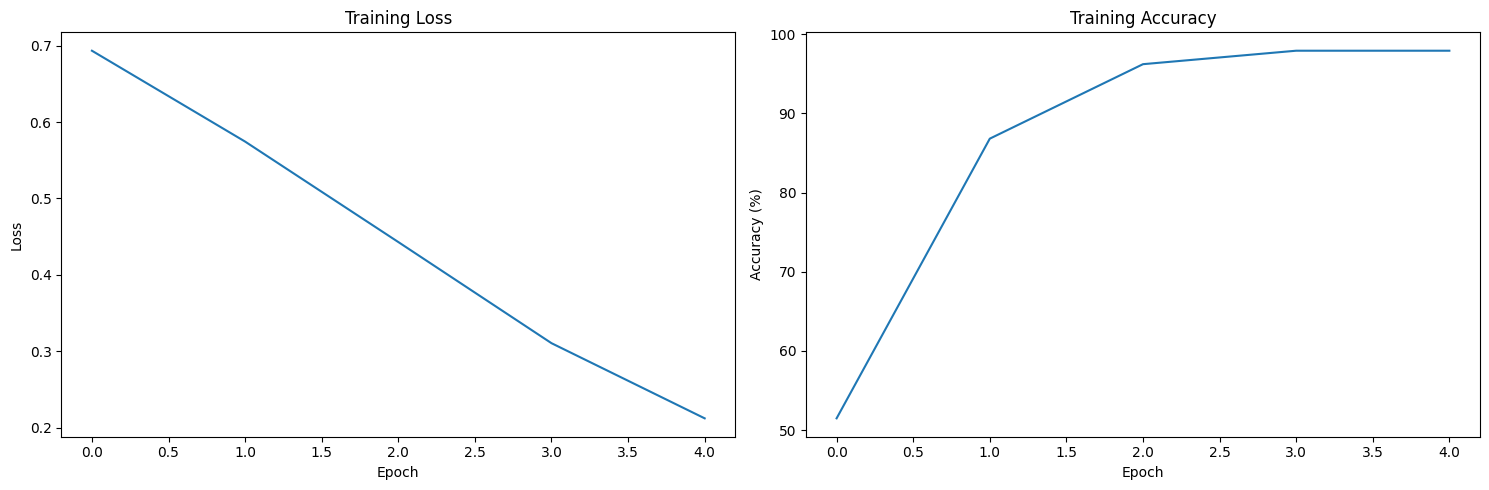

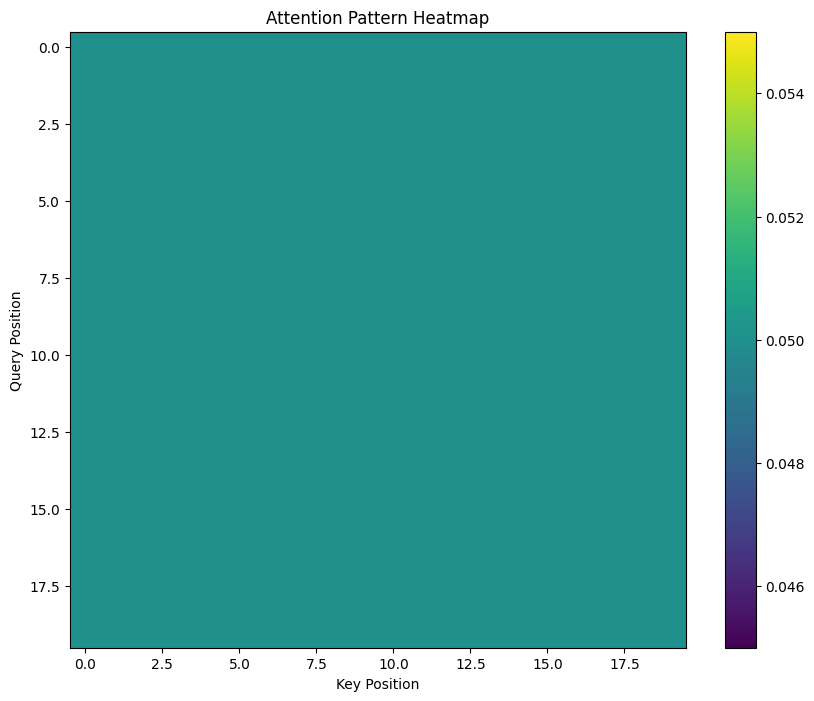

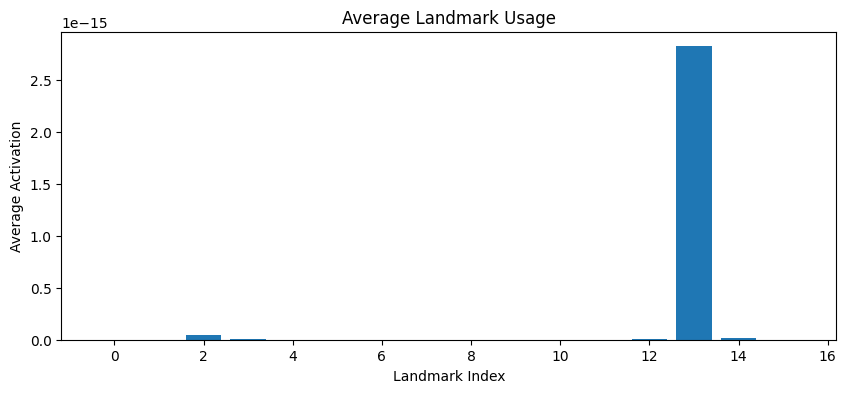

In [21]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['loss'])
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    ax2.plot(history['accuracy'])
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

def main():
    # Hyperparameters
    vocab_size = 1000
    embed_dim = 64
    num_classes = 2
    batch_size = 32

    # Create dataset and dataloader
    dataset = ToyTextDataset()
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    model = SimpleTextClassifier(vocab_size, embed_dim, num_classes)

    # Train model
    history = train_model(model, train_loader)

    # Analyze results
    plot_training_history(history)
    visualize_attention(model, train_loader)
    analyze_landmark_usage(model, train_loader)

if __name__ == "__main__":
    main()